## 首先DBSCAN过滤噪声点

数据：可从宽表获取，需包含start_gps,bi_state,city_id,need_last_order字段

算法：DBSCAN，可直接调用scikit-learn库中相应函数

关键参数：eps表示半径，min_sample表示最小点数量。即半径为eps的范围至少包含min_sample个点，否则视为噪声点

data: 26034
clustering...
cluster completed! use time: 109.119170
Estimated number of clusters: 10
number of non clustering points:1222


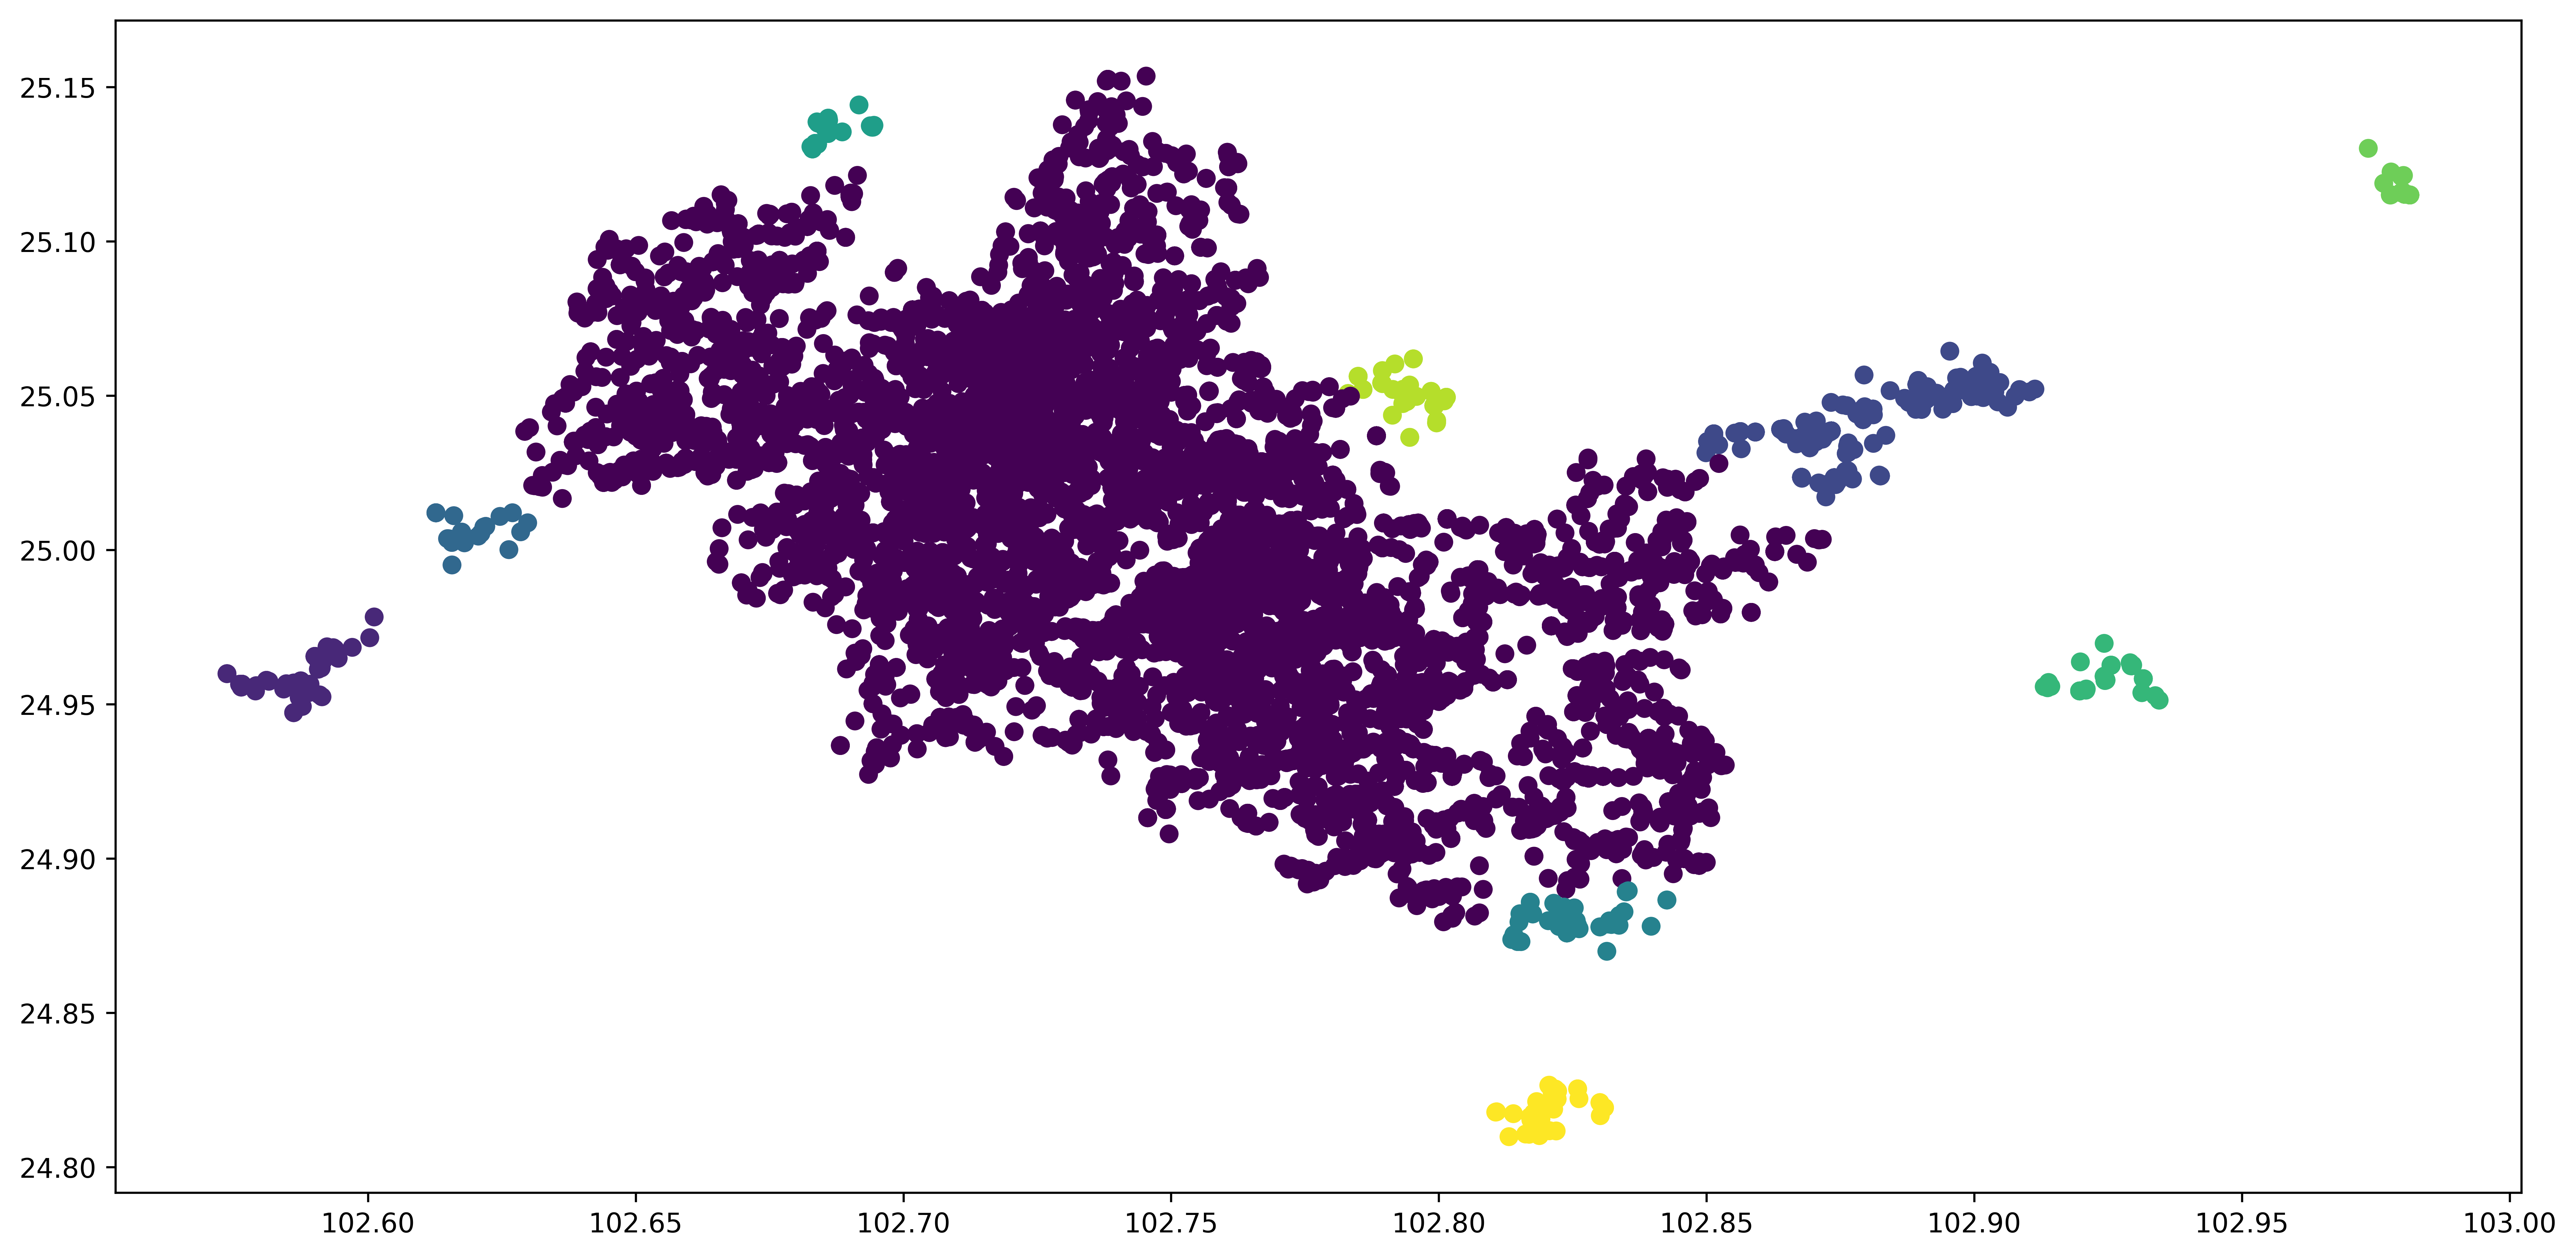

CPU times: user 1min 57s, sys: 527 ms, total: 1min 58s
Wall time: 1min 57s


In [58]:
%%time
import numpy as np
import pandas as pd
import time
from math import radians, cos, sin, asin, sqrt
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN

plt.rcParams['font.sans-serif'] = ['SimHei']  # show chinese
plt.rcParams['axes.unicode_minus'] = False  # show minus sign

def haversine(x, y):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    Args:
    x: [lon1, lat1]
    y: [lon2, lat2]
    """

    lon1, lat1, lon2, lat2 = x[0], x[1], y[0], y[1]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r * 1000

def dbscan_clustering(gps, eps, min_sample):
    print 'data: %d'%gps.shape[0]
    print 'clustering...'
    start = time.time()
    
    db = DBSCAN(eps=eps, min_samples=min_sample, metric=haversine, n_jobs=-1).fit(gps)
    
    print 'cluster completed! use time: %f' % (time.time()-start) 

    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_nonclusters = int(np.sum([1 for i in labels if i == -1]))
        
    print 'Estimated number of clusters: %d\nnumber of non clustering points:%d'%(n_clusters_, n_nonclusters)

    non_cluster_point_mask = (labels != -1)
    gps_filter = gps[non_cluster_point_mask]
    cluster_labels = [i for i in labels if i != -1]
        
    return gps_filter, cluster_labels

def load_gps(path, city, cancle_flag=True):
    df = pd.read_csv(path, delimiter = '\t', error_bad_lines=False)
    if cancle_flag:
        df = df[(df['start_gps'].notnull()) & (df['bi_state']==4) & (df['city_id']==city) & (df['need_last_order']=='Y')]
    else:
        df = df[df['start_gps'].notnull() & (df['city_id']==city) & (df['need_last_order']=='Y')]
    gps = list(df['start_gps'])
    gps_list = []
    for i in gps:
        gps_list.append(list(map(float,i.split(','))))
    return np.array(gps_list)[:100000]

def plot_results(gps, label):
    plt.figure(figsize=(16, 8), dpi=600)    
    plt.scatter(gps[:, 0], gps[:, 1], c=label)
    plt.show()

gps = load_gps('/opt/test/liguangkai/cluster/gps_data_3city.csv', 541, False) # gps_data_month9_beta
gps_filter, labels = dbscan_clustering(gps, eps=1000, min_sample=40)
plot_results(gps_filter, labels)

## 层次聚类得到商圈簇

算法：Agglomerative Clustering，直接调用scikit-learn库函数

关键参数：聚类个数n_clusters，（我一般先估算合适商圈面积，假设为a，然后查该城市市区面积A，则聚类个数为A/a）

40 0
aggl clustering time: 33.185370


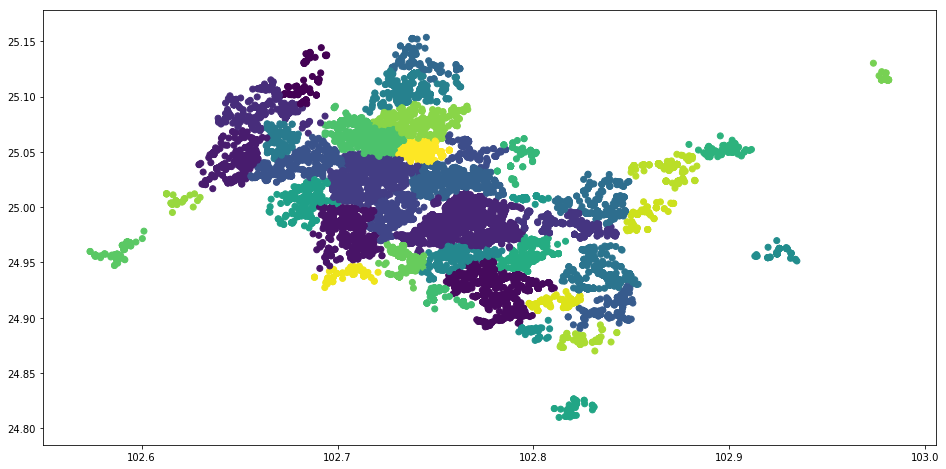

CPU times: user 30.4 s, sys: 4.2 s, total: 34.6 s
Wall time: 34.5 s


In [67]:
%%time
from sklearn.cluster import AgglomerativeClustering
def plot_aggl(gps_filter, n_clusters):
    aggl_start_time = time.time()
    clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
    y_pred = clustering.fit_predict(gps_filter)
    
    n_clusters_ = len(set(y_pred)) - (1 if -1 in y_pred else 0)
    n_nonclusters = int(np.sum([1 for i in y_pred if i == -1]))
    print n_clusters_, n_nonclusters
    print('aggl clustering time: %f' % (time.time()-aggl_start_time))
        
    gps_ = ['%f,%f' % (i[0], i[1]) for i in gps_filter]
    dic = {'gps':gps_,
            'pred':y_pred}
    data = pd.DataFrame(dic)
    data.to_csv("/opt/test/liguangkai/cluster/results/cluster_results_kunming_need40.csv", index=False)
    
    plt.figure(figsize=(16, 8))    
    plt.scatter(gps_filter[:, 0], gps_filter[:, 1], c=y_pred)
    plt.show()

plot_aggl(gps_filter, 40)

In [68]:
%%time
from collections import defaultdict
df_cluster = pd.read_csv('/opt/test/liguangkai/cluster/results/cluster_results_kunming_need40.csv')
df_cluster = df_cluster[df_cluster['pred'] != -1]

cluster_results = defaultdict(list)
label = df_cluster['pred'].tolist()
gps = df_cluster['gps'].tolist()

for i in range(len(label)):
    lst = gps[i].strip().split(',')
    cluster_results[str(label[i])].append([float(i) for i in lst])
print cluster_results.keys()

['24', '25', '26', '27', '20', '21', '22', '23', '28', '29', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '13', '38', '11', '10', '39', '12', '15', '14', '17', '16', '33', '18', '31', '30', '37', '36', '35', '34', '19', '32']
CPU times: user 63.4 ms, sys: 0 ns, total: 63.4 ms
Wall time: 63.2 ms


## alpha shape算法得到商圈边界

已写好alpha shape代码，可直接调用。

当商圈边界点较少时，alpha shape算法有问题，此时捕获异常，用graham scan算法来获取边界。

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
completed!


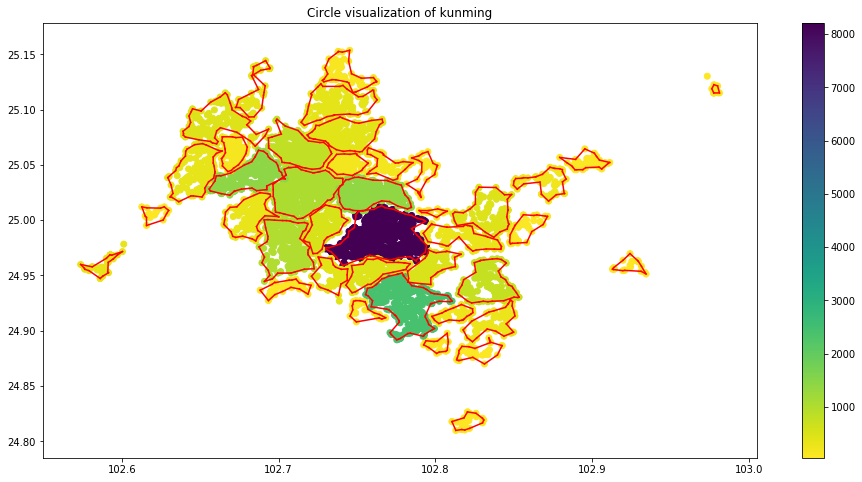

In [69]:
import sys 
sys.path.append('/opt/sy_note/user/liguangkai/heat map/') 
sys.path.append('/opt/sy_note/user/liguangkai/scheduling point')

from alpha_shape import alpha_shape
from graham_scan import graham_scan
from matplotlib import pyplot as plt
from plot_point_hull import scatter_plot_set
from processBar import ShowProcess
from time import sleep

def get_hull_points(cluster_results, max_alpha=150):
    points_set = []
    hull_set = []
    color_degree = []
    
    bar = ShowProcess(len(cluster_results.keys()), 'completed!')

    for label in list(cluster_results.keys()):
        pts = cluster_results[label]
        pts_len = len(pts)
        pts = set([tuple(i) for i in pts])
        pts = [list(i) for i in pts]
        if len(pts) > 2:
            color_degree += [pts_len] * len(pts)
            points_set.append(pts)
            alpha = 10
            try:
                concave_hull, _ = alpha_shape(pts, alpha=alpha)
                #print concave_hull
                flag = True
                while flag and alpha<=max_alpha:
                    try:
                        concave_hull, _ = alpha_shape(pts, alpha)
                        hull = concave_hull.exterior.coords[:] #.buffer(0.0001)
                        #print hull
                        alpha += 10
                    except AttributeError:
                        alpha -= 10
                        concave_hull, _ = alpha_shape(pts, alpha)
                        hull = concave_hull.exterior.coords[:] #.buffer(0.0001)
                        flag = False
                    else:
                        flag = True                      
            except (NameError, ValueError, ZeroDivisionError):
                hull = graham_scan(pts, False)
            hull_set.append(hull)
        bar.show_process()      # 显示当前进度
        sleep(0.01)
    return points_set, color_degree, hull_set
        
def scatter_plot_set(points_set, color_degree, hull_set, city_name):
    coords = [i for points in points_set for i in points]
    xs, xy=zip(*coords)
    plt.figure(figsize=(16, 8))
    plt.scatter(xs, xy, c=color_degree, cmap=plt.cm.get_cmap('viridis_r'))
    plt.colorbar()
    if hull_set != None:
        for hull in hull_set:
            for i in range(1,len(hull)+1):
                if i==len(hull): i=0 # wrap
                c0=hull[i-1]
                c1=hull[i]
                plt.plot((c0[0],c1[0]),(c0[1],c1[1]),'r')
    plt.title('Circle visualization of %s' % city_name)
    plt.show()

points_set, color_degree, hull_set = get_hull_points(cluster_results, max_alpha=150)
scatter_plot_set(points_set, color_degree, hull_set, city_name='kunming')

## 一般这个时候我会将各个商圈最远两个点的距离列出，若最大距离在7000-10000左右比较合适，否则回到第二步，调整聚类个数

In [70]:
import sys
sys.path.append('/opt/sy_note/user/liguangkai/scheduling point')
from mostFarPoint import MostFarPoint
dist = []
for hull in hull_set:
    dist.append(MostFarPoint(hull).calculate_distance()['distance'])
sorted(dist, reverse=True)

[6993.788743597105,
 6735.341217163329,
 6455.736928578831,
 6034.689654132664,
 5765.240246730356,
 5695.376601972474,
 5677.21412498113,
 5664.851834452625,
 5471.812314042533,
 5245.87860734802,
 5238.834562549811,
 5122.461906866574,
 5069.185761105444,
 5044.556642414091,
 4943.411412306686,
 4908.083191477205,
 4873.823553836358,
 4766.03738089611,
 4732.39316686844,
 4612.137018604638,
 4418.103519514784,
 4231.292588140297,
 4074.23769448697,
 3647.0705728364733,
 3631.8053440136455,
 3578.3264059900257,
 3515.967351315564,
 3310.0686149040152,
 3254.576141632861,
 3252.3126519141842,
 3057.485148322043,
 2726.421920216323,
 2686.65848826139,
 2645.9039675106096,
 2293.7820915993134,
 2197.9064380275213,
 2154.7592874304373,
 2131.5848238281624,
 1809.9775658056105,
 900.8718614606736]

In [71]:
np.save('/opt/test/liguangkai/cluster/results/need_points_kunming40.npy', np.array(points_set))
np.save('/opt/test/liguangkai/cluster/results/need_hull_kunming40.npy', np.array(hull_set))

In [72]:
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster, HeatMapWithTime

#　北京：[39.904989,116.405285]　　深圳：[22.61667，114.06667]   郑州：[113.65， 34.76]  武汉：[30.52, 114.31] 重庆：[29.59, 106.54] 
#  成都：[30.67, 104.06]  哈尔滨：[45.75, 126.63]  长沙：[28.21, 113]  杭州：[30.26, 120.19] 天津：[39.13, 117.2]  长春：[43.90, 125.32]
#  佛山：[23.02, 113.12]  石家庄：[31.86, 117.27]  济南：[36.65, 117]  东莞：[23.04, 113.75], 南昌：[28.68, 115.89]  合肥：[31.86, 117.27]
# 贵阳：[26.57, 106.71]  南宁：[22.84, 108.33] 昆明：[25.04, 102.73]

fmap = folium.Map(location=[25.04, 102.73],
#                   tiles = 'Mapbox Bright',
                  zoom_start=12)

points = points_set
points_ = []
for cluster in points:
    for point in cluster:
        points_.append([point[1], point[0]])

hull = hull_set

for hul in hull:
    hull_ = []
    for point in hul:
        hull_.append([point[1], point[0]])
    folium.PolyLine(hull_, color="blue", weight=1.5, opacity=1).add_to(fmap)

HeatMap(points_, radius=12).add_to(fmap)

fmap.save('./folium visual/need_kunming_40.html')

## 生成sql语句，交由金丹执行写库

记得修改参数city, circle_type, city_name

In [73]:

def generate_sql(city, circle_type, city_name):
#     city = 2 #
#     circle_type = 3 #

    circle_id_hull = {}
    l = len(points_set)
    center_gps = [np.array(i).mean(axis = 0).tolist() for i in points_set]
    circle_id = ['need_circle_city%s_%d'%(str(city), i) for i in range(1, l+1)] #
    name = ['需求商圈%d'%i for i in range(1, l+1)] #
    print l
    for i in range(l):
        circle_id_hull[circle_id[i]] = hull_set[i]

    sql_sentence = []
    for i in range(l):
        sql_sentence.append("INSERT INTO `sydm_smart`.`t_circle_info` (`system_type`, `circle_type`, `circle_id`, `name`, `center_gps`, `city_id`, `primary_industry_id`,`secondary_industry_id`, `creator`, `create_time`, `updater`, `update_time`, `region`, `shape`, `radius`, `remark`, `is_del`) VALUES ( '1', '%s', '%s', '%s', '%s,%s', '%s', '3', '28', '算法生成', '2018-12-21 12:00:00', '算法生成', '2018-12-21 12:00:00', '', '0', '0.00', '', '0');" 
                        %(str(circle_type), circle_id[i], name[i], str(center_gps[i][0]), str(center_gps[i][1]), str(city)))
    for i in range(l):
        for j in range(len(circle_id_hull[circle_id[i]])):
            sql_sentence.append("INSERT INTO `t_circle_boundary` (`circle_id`, `gps`, `sort_id`, `is_del`) VALUES ('%s', '%s,%s', '%d', '0');"%(circle_id[i],str(circle_id_hull[circle_id[i]][j][0]),str(circle_id_hull[circle_id[i]][j][1]),j+1))
    
    with open('/opt/test/liguangkai/cluster/results/need_circle_sql_%s.txt'%city_name, 'w') as f:
        for i in sql_sentence:
            f.write(i+'\n')
            
            
generate_sql(city=541, circle_type=3, city_name='kunming')


40
